In [1]:
import os
import sys

AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../AERO_LIB'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

import libs.AeroBDSM as aero

PyXfoil_dir = os.path.abspath(os.path.join('../Xfoil/'))
if PyXfoil_dir not in sys.path:
    sys.path.append(PyXfoil_dir)

import py_Xfoil as pxf
from isolated_plane import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

from pandas import DataFrame, read_excel
%config InlineBackend.figure_format = 'svg'

# Задание формата шрифта для графиков
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

import warnings
warnings.filterwarnings("ignore")

In [2]:
''' Геометрические параметры изолированной несущей поверхности '''

# Параметры крыла
l_kr = 6            # размах крыла [м]
l_c = 3             # длина одной консоли [м]
b_b = 1             # бортовая хорда [м]
b_1 = 1             # концевая хорда [м]
chi_0 = radians(15)  # угол стреловидности по передней кромке [рад]
chi_1 = radians(15)      # угол стреловидности по задней кромке [рад]

# Параметры профиля крыла
cc_b = 0.08            # относительная толщина профиля бортовой хорды [-]
cc_1 = 0.08            # относительная толщина профиля концевой хорды [-]
cc = (cc_b + cc_1) / 2  # средняя относительная толщина профиля [-]
xx_c = 0.4              # относительная координата положения максимальной толщины [-]
hb = 1e-5               # относительная высота бугорков профиля [-]
rr_0 = 0                # относительный радиус скругления передней кромки [-]
aa = 0.5                # отношение геометрического параметра профиля `a` в долях рассматриваемой хорды [-]

xx_0 = 0                # относительная координата центра вращения в долях САХ (от носка САХ) относительно которой считаются моменты
xx_t = None             # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях рассматриваемой хорды
T_s = None              # средняя температура поверхности крыла, К

# Расчет геометрических параметров

S_kr = (b_b + b_1) / 2 * l_kr
lambda_kr = l_kr ** 2 / S_kr
zeta_kr = b_1 / b_b
chi_05 = atan(tan(chi_0) - 2 / lambda_kr * (1 / zeta_kr - 1) / (1 / zeta_kr + 1))

''' Необходиые функции '''

def c_y_to_c_ya(alpha, cy, cx):
    '''
    Перевод коэффициента нормальной силы в коэффициент подъемной силы
    (Связанная СК -> Скоростная СК)

    Ввод: alpha: float - угол атаки, град
          cy: float - коэффициет нормальной силы
          cx: float - коэффициент продольной силы

    Вывод: c_y_a: float - коэффициент подъемной силы
    '''

    # Коэффициент подъемной силы
    c_y_a = cy * np.cos(np.deg2rad(alpha)) - cx * np.sin(np.deg2rad(alpha))

    # Результат
    return c_y_a

def c_x_to_c_xa(alpha, cy, cx):
    '''
    Перевод коэффициента продольной силы в коэффициент силы сопротивления
    (Связанная СК -> Скоростная СК)

    Ввод: alpha: float - угол атаки, град
          cy: float - коэффициет нормальной силы
          cx: float - коэффициент продольной силы

    Вывод: c_x_a: float - коэффициент силы сопротивления
    '''

    # коэффициент силы сопротивления
    c_x_a = cy * np.sin(np.deg2rad(alpha)) + cx * np.cos(np.deg2rad(alpha))

    # результат
    return c_x_a

# Функции из Фролова
def get_c_ya_alpha_rect(lambd, c_y_a_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_y_a_alpha_profile) / (1 + c_y_a_alpha_profile*0.375/lambd)

    return c_y_a_alpha

def get_c_ya_alpha_profile_rect(lambd, c_y_a_alpha):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для профиля прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha: float - производная коэффициена c_y_a прямоугольного крыла по углу атаки
    Вывод:  c_y_a_alpha_profile: float - производной коэффициента c_y_a по углу атаки профиля прямоугольного крыла, 1/рад
    '''
    c_y_a_alpha_profile = c_y_a_alpha / (1 - c_y_a_alpha * 0.375 / lambd)
    return c_y_a_alpha_profile

def get_c_ya_alpha_rect_eta(lambd, z, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            z: float - обратное сужение крыла (z = 1/eta = 1/(b_0/b_k))
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    k = 0.995 # Поправочный коэффициент, учит. сужение крыла для 0,2 < z < 1,0
    E = 1 + 2*z / lambd / (1 + z) # Поправка Джонса, учитывает фактоор скорости по кромке, равна отношению периметра в плане к размаху

    c_ya_alpha = k * c_ya_alpha_profile / (E + c_ya_alpha_profile / np.pi / lambd)
    return c_ya_alpha

def get_c_ya_alpha_chi(lambd, chi_05, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла со стреловидностью
    
    Ввод:   lambd: float - удлинение крыла
            chi_05: float - угол стреловидности по линии средин хорд, рад
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_ya_alpha_profile * np.cos(chi_05)) / (1 + (c_ya_alpha_profile * np.cos(chi_05)) / np.pi / lambd)

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons_low_lambda(lambd):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1) по формуле Джонса
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''

    c_y_a_alpha = np.pi * lambd / 2

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons(lambd, chi_pk, chi_zk, z):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1)
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''
    eta = 1 / z # сужение крыла
    # Отношение полупериметра крыла к его размаху для трапециевидных крыльев
    pp = 1/2 * (1/np.cos(chi_pk) + 1/np.cos(chi_zk)) * (2 / lambd / (eta + 1))

    c_y_a_alpha = 2 * np.pi * lambd / (pp * lambd + 2)

    return c_y_a_alpha

def get_c_xa_i(lambd, z, chi_025, c_y_a):
    '''
    Расчет коэффициента индуктивного сопротивления крыла

    Ввод: 
        lambd: float - удлинение крыла
        z: float - облатное сужение крыла
        chi_025: float - угол стреловидности по линии 1/4 хорд, рад
        c_y_a: float - коэффициент подъемной силы крыла
    Вывод:
        c_xa_i: float - коэффициент индуктивного сопротивления
    '''
    eta = 1 / z # сужение крыла
    delta = 0.002 * lambd / np.cos(chi_025) * (3.1 - 14/eta + 20/eta/eta - 8/eta/eta/eta)

    lambd_eff = lambd / (1 + delta) # эффективное удлинение крыла
    c_xa_i = c_y_a ** 2 / np.pi / lambd_eff

    return c_xa_i

''' Результаты расчета в Ansys '''

alpha_Ansys = np.array([-16, -12,  -8,  -4,  -2,   0,   2,   4,   8,  12,  16])

cya_Ansys = np.array([-0.74234465, -0.66050652, -0.43800317, -0.16033446, -0.01244874, 0.11160967,  0.2854629 ,  0.4335265 ,  0.71771431,  0.96169333, 1.0880436])
cxa_Ansys = np.array([0.11425316, 0.04806628, 0.02512978, 0.01238975, 0.0101876, 0.00856573, 0.01467258, 0.02116719, 0.04216895, 0.07203864, 0.11295783])
mza_Ansys = np.array([-0.42764668, -0.35782076, -0.23319939, -0.06856277,  0.02115481, 0.04987085,  0.20257022,  0.29282613,  0.46530036,  0.6076245, 0.67221103])

# Параметры невозмущенного потока

M = 0.2                             # Число Маха
H_Ansys = 0                         # Высота полета

rho_Ansys = atmo.rho(H_Ansys)       # Плотность воздуха
a_Ansys = atmo.a(H_Ansys)           # Скорость звука
nu_Ansys = 15.06e-6                 # Кинематическая вязкость воздуха

V = M * a_Ansys                     # Скорость потока
q = rho_Ansys * V ** 2 / 2          # Скоростной напор

Re_Ansys = V * b_b / nu_Ansys       # Число Рейнольдса для крыла

In [3]:
'''Создание экземпляров класса ИНП'''

Airfoil = SubsonicProfile(b_b, cc, xx_c, rr_0, hb, 'naca')      # Создание экземпляра класса дозвукового профиля
IP = IsolatedPlane(S_kr, lambda_kr, zeta_kr, chi_05, Airfoil)   # Создание экземпляра класса изолированного крыла

In [4]:
''' Расчет АДХ профиля из Xfoil '''

airfoil = 'NACA2215'        # Имя профиля (имя профиля или файл с координатами профиля)
Re = Re_Ansys               # Число Рейнольдса
iter = 150                  # Число итераций для панельного метода
alpha_min = 0               # Наименьшее значение угла атаки
alpha_max = 15              # Наибольшее значение угла атаки
step = 2                    # Шаг по углу атаки

Res_ADX = pxf.get_ADX(airfoil, Re, alpha_min, alpha_max, step, iter)
alpha_airfoil, c_ya_airfoil, c_xa_airfoil = Res_ADX['alpha'], Res_ADX['c_ya'], Res_ADX['c_xa']

In [5]:
''' Расчет по Лебедеву-Чернобровкину '''

# Массив АД коэффициентов
cya_LiCH, cxa_LiCH, mza_LiCH = [], [], []

# Массив углов атаки
alphas = np.linspace(0, 20, 31)

# Расчет по Лебедеву-Чернобловкину
for alf in alphas:
    cxa_LiCH.append(IP.c_xa(M, np.deg2rad(alf)))
    cya_LiCH.append(IP.c_ya(M, np.deg2rad(alf)))

''' Расчет подъёмной силы изолированного крыла конечного размаха '''

# Расчет критического угла атаки
alpha_kr = aero.get_alpha_cr_IsP(M, lambda_kr).Value
alpha_kr = np.rad2deg(alpha_kr)

# Производная по углу атаки профиля крыла
c_y_a_alpha_Xfoil = (c_ya_airfoil[3] - c_ya_airfoil[0]) / (alpha_airfoil[3] / 57.3 - alpha_airfoil[0] / 57.3)

# Производные по формуле Фролова
c_y_a_alpha_1 = get_c_ya_alpha_rect(lambda_kr, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_2 = get_c_ya_alpha_rect_eta(lambda_kr, 1, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_3 = get_c_ya_alpha_chi(lambda_kr, chi_05, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_4 = get_c_ya_alpha_Dzhons_low_lambda(lambda_kr) / 57.3
c_y_a_alpha_5 = get_c_ya_alpha_Dzhons(lambda_kr, chi_0, chi_1, 1) / 57.3

# Дельта кривой c_y_a (чему равно значение кривой при alpha=0) если профиль симметричный - дельта = 0
delta_c_ya = c_ya_airfoil[0] / (1 + c_y_a_alpha_Xfoil * 0.375 / lambda_kr)

In [6]:
c_y_a_alpha_Ansys = (cya_Ansys[3] - cya_Ansys[0]) / (alpha_Ansys[3] / 57.3 - alpha_Ansys[0] / 57.3)
print('для профиля ', c_y_a_alpha_Xfoil)
print('для Ansys ', c_y_a_alpha_Ansys)

для профиля  6.441475
для Ansys  2.7790986572500005


In [7]:
''' Расчет подъёмной силы изолированного крыла конечного размаха '''

def get_derivative_function(x, y):
    '''
    Расчет функции производной
    Ввод: y: numpy.ndarray - массив значений функции
          x: numpy.ndarray - массив аргументов функции

    Вывод: y_: numpy.ndarray - массив значений производной функции
    '''

    # интерполяция
    f_int = interp1d(x, y)

    # производная функции
    y_ = np.gradient(f_int(x), x)

    # результат
    return y_

def get_integration_function(x_, y_, cya_0):
    '''
    Расчет функции по её производной
    Ввод: y_: numpy.ndarray - массив значений производной функции
          x_: numpy.ndarray - массив аргументов производной функции
          cya_0: float - значение функции при первом значении аргумента

    Вывод: y: numpy.ndarray - массив значений функции
    '''

    # интегрирвоание
    y = cumtrapz(y_, x_, dx = 0.01, initial=0)

    # значение функции
    y = y + cya_0

    # Результат
    return y

cya_0 = delta_c_ya
c_y_alpha_pr_s = get_derivative_function(alpha_airfoil, c_ya_airfoil)
c_y_a_after_integr = get_integration_function(alpha_airfoil, c_y_alpha_pr_s, cya_0)

c_y_alpha_kr_s = []

for cya_alf in c_y_alpha_pr_s:
    cya_alf_kr = get_c_ya_alpha_rect_eta(lambda_kr, 1, cya_alf * 57.3)
    c_y_alpha_kr_s.append(cya_alf_kr / 57.3)

c_y_a_kr = get_integration_function(alpha_airfoil, c_y_alpha_kr_s, cya_0)

''' Формирование массива аналитических кривых '''

def cya_non_linear(alpha, c_y_a_alpha, c_y_a_max, alpha_kr):
    '''
    Функция для нелинейного участка кривой c_y_a (alpha)
    
    Ввод: alpha: float - угол атаки, град
          c_y_a_alpha: float - производная линейного участка кривой c_y_a (alpha) на малых углах атаки, 1/град
          c_y_a_max: float - максимальное значение коэффициента c_y_a
          alpha_kr: float - значение критического угла атаки, град

    Вывод: c_y_a: float - значение коэффициента подъемной силы на нелинейном участке
    '''
    
    # Первый участок - парабола касается линейного участка кривой c_y_a (alpha)
    # Условие для построения параболы: 1. касание линейного участка слева
    #                                  2. равенство значений прямой и параболы в точке касания
    #                                  3. вершина параболы по y лежит в точке c_y_a_max
    #                                  4. вершина параболы по x лежит в точке alpha_kr

    if c_y_a_max >= c_y_a_alpha*alpha_kr:
        c_y_a_max = c_y_a_alpha*alpha_kr
        
        x1 = 90

        def get_line_non_linear(x):
            # b = c_y_a_max / (1 + ((alpha_kr) / (x1)))
            # k = -b / x1

            k = - c_y_a_max / (x1 - alpha_kr)
            b = - k * x1

            y = k*x + b

            return y

        if alpha<0:
            if np.abs(alpha) <= np.abs(alpha_kr):
                return 2 * delta_c_ya - (np.abs(alpha) * c_y_a_alpha + delta_c_ya)
            if np.abs(alpha_kr) < np.abs(alpha) <= np.abs(x1):
                return 2 * delta_c_ya - (delta_c_ya + get_line_non_linear(np.abs(alpha)))
            
        else:
            if np.abs(alpha) <= np.abs(alpha_kr):
                return (np.abs(alpha) * c_y_a_alpha + delta_c_ya)
            if np.abs(alpha_kr) < np.abs(alpha) <= np.abs(x1):
                return delta_c_ya + get_line_non_linear(np.abs(alpha))

    else:
        # дискриминант
        D = (2*delta_c_ya - 2*c_y_a_max)**2 - 4*c_y_a_alpha*(2*c_y_a_max*alpha_kr - c_y_a_alpha*alpha_kr**2 - 2*delta_c_ya*alpha_kr)
        
        # координата по alpha точки касания параболы и прямой
        x0 = (-(2*delta_c_ya - 2 * c_y_a_max) - np.sqrt(D)) / 2 / c_y_a_alpha

        # коэффициент a в уравнении для параболы
        a = c_y_a_alpha / (2 * (x0 - alpha_kr))
        # коэффициент b в уравнении для параболы
        b = -2*a*alpha_kr
        # коэффициент c в уравнении для параболы
        c = c_y_a_max + a*alpha_kr**2

        # уравнение искомой параболы
        def parab_new(x):
            return (a*x**2 + b*x + c)
        
        # Прямая второго участка - касательна к параболе и приходит в 0 на угле 90 градусов
        
        # координаты конечной точки прямой
        x2 = 90
        y2 = 0
        
        # дискриминант
        D1 = 4*(x2**2)*(a**2) - 4 * a * (y2 - b*x2-c)

        # координата точки касания прямой к параболе
        x1 = (2*x2*a + np.sqrt(D1)) / 2 / a
        # коэффициент k в уравнении прямой
        k = 2*a*x1 + b
        # коэффициент d в уравнении прямой
        d = - k*x2 + y2

        # уравнение искомой прямой
        def line(xx):
            return k*xx + d

        # результат
        if alpha<0:
            if np.abs(alpha) < np.abs(x0):
                return 2 * delta_c_ya - (np.abs(alpha) * c_y_a_alpha + delta_c_ya)
            if np.abs(x0) <= np.abs(alpha) <= np.abs(x1):
                return 2 * delta_c_ya - parab_new(np.abs(alpha))
            if np.abs(alpha) > np.abs(x1):
                return 2 * delta_c_ya - line(np.abs(alpha))
        else:
            if np.abs(alpha) < np.abs(x0):
                return alpha * c_y_a_alpha + delta_c_ya
            if np.abs(x0) <= np.abs(alpha) <= np.abs(x1):
                return parab_new(alpha)
            if np.abs(alpha) > np.abs(x1):
                return line(alpha)

def get_cya_max(lam):
    # TODO: Добавить аргумент число Маха
    # TODO: Исправить фукнцию

    cyamax_array = np.linspace(0.8, 1, 51)
    lambda_array = np.linspace(6, 4, 51)

    f = interp1d(lambda_array, cyamax_array)

    cya_max = f(lam)
    # расчет по этому графику приводит к очень низкому макс суа
    return 0.9 # пока фукнция будет возвращать такое число

cya_max = get_cya_max(lambda_kr)

# Формирование массива аналитических кривых
alpha_analit = np.linspace(-50, 50, 101)
cya_analit_1, cya_analit_2, cya_analit_3, cya_analit_4, cya_analit_5 = [], [], [], [], []

for aa in alpha_analit:
    cya_analit_1.append(cya_non_linear(aa, c_y_a_alpha_1, cya_max, alpha_kr))
    cya_analit_2.append(cya_non_linear(aa, c_y_a_alpha_2, cya_max, alpha_kr))
    cya_analit_3.append(cya_non_linear(aa, c_y_a_alpha_3, cya_max, alpha_kr))
    cya_analit_4.append(cya_non_linear(aa, c_y_a_alpha_4, cya_max, alpha_kr))
    cya_analit_5.append(cya_non_linear(aa, c_y_a_alpha_5, cya_max, alpha_kr))

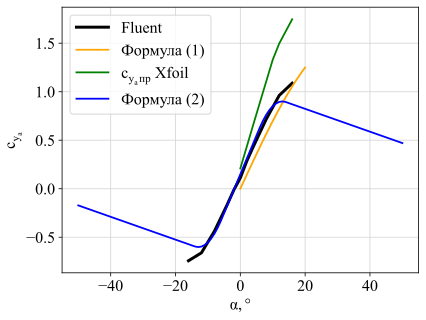

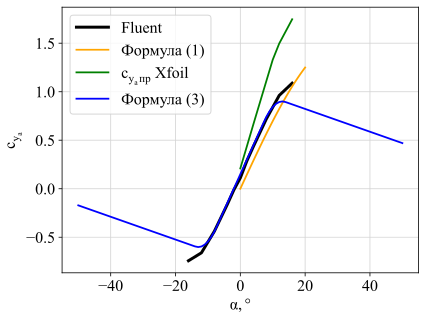

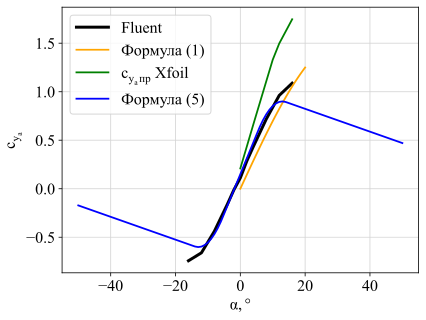

In [8]:
''' Графики подъемной силы крыла '''

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
# plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_1 + delta_c_ya, lw = 1.8, color = 'blue')
# plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_1 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')
# plt.plot(alpha_airfoil, c_y_a_kr, label = 'По произв.', lw = 1.8, color = 'red')
plt.plot(alpha_analit, cya_analit_1, label = 'Формула (2)', lw = 1.8, color = 'blue')
plt.plot()
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
# plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_2 + delta_c_ya, lw = 1.8, color = 'blue')
# plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_2 + delta_c_ya, label = 'Формула (3)', lw = 1.8, color = 'blue')
# plt.plot(alpha_airfoil, c_y_a_kr, label = 'По произв.', lw = 1.8, color = 'red')
plt.plot(alpha_analit, cya_analit_2, label = 'Формула (3)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
# plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_3 + delta_c_ya, color = 'blue')
# plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_3 + delta_c_ya, label = 'Формула (5)', lw = 1.8, color = 'blue')
# plt.plot(alpha_airfoil, c_y_a_kr, label = 'По произв.', lw = 1.8, color = 'red')
plt.plot(alpha_analit, cya_analit_3, label = 'Формула (5)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

# plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
# plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
# plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
# # plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_4 + delta_c_ya, color = 'blue')
# # plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_4 + delta_c_ya, label = 'Формула (6)', lw = 1.8, color = 'blue')
# plt.plot(alpha_airfoil, c_y_a_kr, label = 'По произв.', lw = 1.8, color = 'red')
# plt.plot(alpha_analit, cya_analit_4, label = 'Формула (6)', lw = 1.8, color = 'blue')
# plt.ylabel('$c_{y_a}$')
# plt.xlabel('$\\alpha, \degree$')
# plt.grid(color = 'lightgray')
# plt.legend(loc = 'best')
# plt.show()

# plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
# plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
# plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
# # plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_5 + delta_c_ya, color = 'blue')
# # plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_5 + delta_c_ya, label = 'Формула (7)', lw = 1.8, color = 'blue')
# plt.plot(alpha_airfoil, c_y_a_kr, label = 'По произв.', lw = 1.8, color = 'red')
# plt.plot(alpha_analit, cya_analit_5, label = 'Формула (7)', lw = 1.8, color = 'blue')
# plt.ylabel('$c_{y_a}$')
# plt.xlabel('$\\alpha, \degree$')
# plt.grid(color = 'lightgray')
# plt.legend(loc = 'best')
# plt.show()

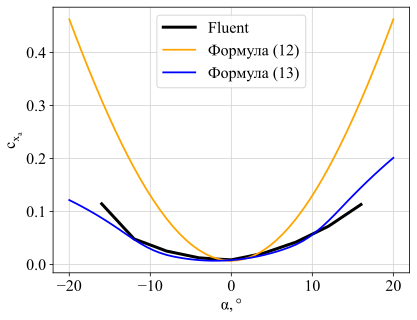

In [9]:
''' Сопротивление крыла конечного размаха '''

def get_c_xa_i(alpha, lambd, z, chi_025,c_ya_alpha, c_y_a, alpha0):
    '''
    Расчет коэффициента индуктивного сопротивления крыла

    Ввод: 
        lambd: float - удлинение крыла
        z: float - облатное сужение крыла
        chi_025: float - угол стреловидности по линии 1/4 хорд, рад
        c_y_a: float - коэффициент подъемной силы крыла
    Вывод:
        c_xa_i: float - коэффициент индуктивного сопротивления
    '''
    eta = 1 / z # сужение крыла
    delta = 0.002 * lambd / np.cos(chi_025) * (3.1 - 14/eta + 20/eta/eta - 8/eta/eta/eta)

    lambd_eff = lambd / (1 + delta) # эффективное удлинение крыла
    # c_xa_i = c_y_a ** 2 / np.pi / lambd_eff
    c_xa_i = c_y_a * np.sin(alpha -alpha0) -  c_y_a**2 / c_ya_alpha * np.cos(alpha-alpha0) + c_y_a ** 2 / np.pi / lambd_eff * np.cos(alpha-alpha0)
    return c_xa_i

cxa0_LiCH = []
cxa_prof_LiCH = []
cxa_LiCH = []
cy_array = []
cxa_i_array = []

alpha_for_cx = np.linspace(-20, 20, 51)

for alf in alpha_for_cx:
    cxa0_LiCH.append(IP.c_xa0(M, 0.9))
    cxa_LiCH.append(IP.c_xa(M, np.deg2rad(alf)))
    cy_array.append(cya_non_linear(alf, c_y_a_alpha_2, cya_max, alpha_kr))
    cxa_i_array.append(get_c_xa_i(np.deg2rad(alf), lambda_kr, zeta_kr, chi_05, (c_y_a_alpha_2*57.3), cya_non_linear(alf, c_y_a_alpha_2, cya_max, alpha_kr), np.deg2rad(-2)))

cxa_prof_LiCH = IP.c_xa_pr(M)

# # Индуктивное сопротивление
# cxai = get_c_xa_i(lambda_kr, zeta_kr, np.rad2deg(chi_05), np.array(cy_array))

plt.plot(alpha_Ansys, cxa_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alpha_for_cx, cxa_LiCH, label = 'Формула (12)', lw = 1.8, color = 'orange')
plt.plot(alpha_for_cx, (np.array(cxa_prof_LiCH) + np.array(cxa_i_array)), label = 'Формула (13)', lw = 1.8, color = 'blue')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.ylabel('$c_{x_a}$')
plt.xlabel('$\\alpha, \degree$');

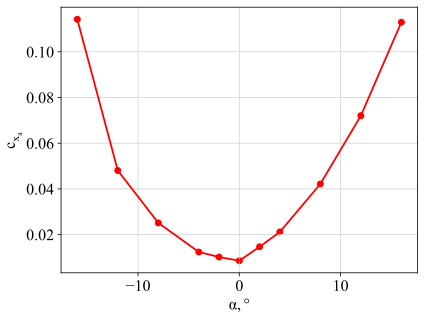

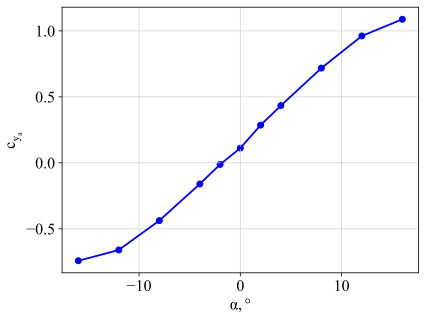

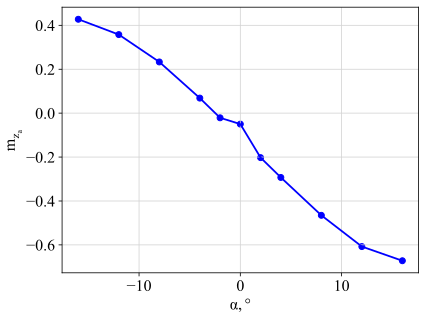

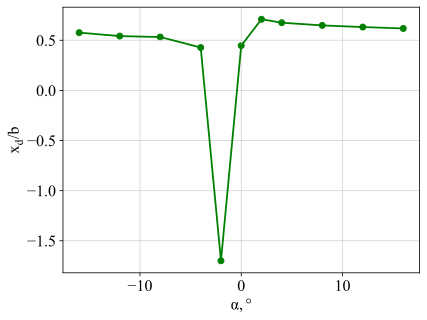

In [10]:
''' Графики для РПЗ '''

# График c_x_a (alpha)
plt.plot(alpha_Ansys, cxa_Ansys, color = 'red', lw = 1.8)
plt.scatter(alpha_Ansys, cxa_Ansys, color = 'red')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.show()

# График c_y_a (alpha)
plt.plot(alpha_Ansys, cya_Ansys, color = 'blue', lw = 1.8)
plt.scatter(alpha_Ansys, cya_Ansys, color = 'blue')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.show()

# График m_z_a (alpha)
plt.plot(alpha_Ansys,  - (mza_Ansys / cya_Ansys) * cya_Ansys, color = 'blue', lw = 1.8)
plt.scatter(alpha_Ansys, - (mza_Ansys / cya_Ansys) * cya_Ansys, color = 'blue')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$m_{z_a}$')
plt.show()

# График x_d (alpha)
plt.plot(alpha_Ansys, (mza_Ansys / cya_Ansys), color = 'green', lw = 1.8)
plt.scatter(alpha_Ansys, mza_Ansys/cya_Ansys, color = 'green')
plt.grid(color = 'lightgray')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_d/b$')
plt.show()

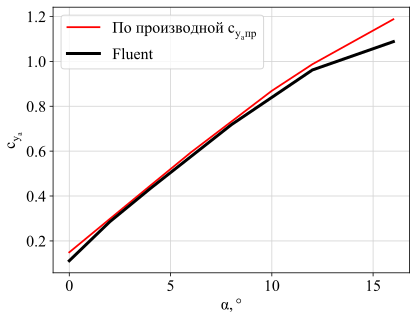

In [11]:
# Графики по производным

plt.plot(alpha_airfoil, c_y_a_kr, label = 'По производной $c_{y_aпр}$', lw = 1.8, color = 'red')
plt.plot(alpha_Ansys[5:], cya_Ansys[5:], label = 'Fluent', lw = 3, color = 'black')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()